# Correlation Network

Correlation network (graph) desribes the strength of correlation among qubit pairs in a system and shows how qubits in a system is correlated. 

In the network:

Nodes: represent the *qubits*.

Edge: represent *how much* the nodes (qubits) are *correlated* by its weight.

The strength can be any value that quantify how a qubit pair is correlated. In previous studies, quantum Mutual Information (MI) is used. Though it remains unknown, we conjecture that Entanglement of Formation (EoF) and various entanglement witnesses are also useful quantities in certain scenario. 

In quantum computing, people can calculate the correlation network of a objective wavefunction, such as the network of the ground state of a Hamiltonian in VQE, in a approximated way, before carrying out quantum computing on the system. 

By this pre-calculation, people can know that

- Which qubits are more active and which qubits are nearly stationary and can be removed.
- The groups of qubits in which the qubits are inter-entangled, so that the computation can be divided into parts.
- Which part of the system is more active and needs higher precision of operation. 
    - So that physics qubits with higher quality can be assigned to it.

We believe that the potential applications shown above make pre-calculation of correlation network very important for near-term quantum computing because

- The number of gates and qubits allowed on near-term quantum devices is very limited.
- The quality of qubits in near-term is not uniform and full-connectivity qubits set will be small.

To address these problems, we provide modules for

- Easily carrying out correlation network approximation from qubit Hamiltonians.
- Finding the optimal mapping to physical qubits based on the correlation network.
- Finding the subsets of qubits which are most correlated.
- Finding the community (correlated group) structure of a correlation network.

## Classical pre-calculation

The classical pre-calculation can be easily carried out as following.

In [1]:
from Precalculation.iTensorCore import run_classcal_precalculation
from HamiltonianGenerator import make_example_LiH
from HamiltonianGenerator.FermionTransform import jordan_wigner

# Generate the problem Hamiltonian
energy_obj = make_example_LiH(fermi_qubit_transform=jordan_wigner)

# Run the classical pre-calculation
classical_res=run_classcal_precalculation(energy_obj.n_qubit,energy_obj.hamiltonian,calc_2DM=True)
print("Energy",classical_res["energy"])
print("Entropy",classical_res["entropy"])

Symmetry: Coov  is used when build the molecule.
Energy -7.877001491818368
Entropy [0.12862023953253907, 0.12862023953253907, 0.04117055463536695, 0.04117055463536695, 0.10195658541252663, 0.10195658541252663]


Because `calc_2DM` is made `True`, reduced two-qubit density matrices of the ground state is also calculated. Here we show how to use them calculated the correlation quantities.

In [2]:
from Utilities.WaveLocalProperties import get_mutual_information_by_2DMs,get_EoF_by_2DMs
 
classical_res["MI"]=get_mutual_information_by_2DMs(classical_res["2DM"])
classical_res["EoF"]=get_EoF_by_2DMs(classical_res["2DM"])

print("Mutual Information",classical_res["MI"].tolist())
print("Entanglement of Formation",classical_res["EoF"].tolist())

Mutual Information [[0.0, 0.05686422974791204, 0.01688342559421084, 0.00923050347926574, 0.0438784337237768, 0.043615348773295606], [0.05686422974791204, 0.0, 0.00923050347926574, 0.016984823342198085, 0.043615348773295606, 0.043794613240691074], [0.01688342559421084, 0.00923050347926574, 0.0, 0.0021556255819239617, 0.0012450419319145478, 0.006317482790596407], [0.00923050347926574, 0.016984823342198085, 0.0021556255819239617, 0.0, 0.006317482790596407, 0.0014123307378750144], [0.0438784337237768, 0.043615348773295606, 0.0012450419319145478, 0.006317482790596407, 0.0, 0.03286268696855375], [0.043615348773295606, 0.043794613240691074, 0.006317482790596407, 0.0014123307378750144, 0.03286268696855375, 0.0]]
Entanglement of Formation [[0.0, 0.0, 8.835554507354273e-09, 0.0, 4.881243695663972e-10, 0.0], [0.0, 0.0, 0.0, 9.1192310723037e-09, 0.0, 1.9359904489429352e-10], [8.835554507354273e-09, 0.0, 0.0, 0.0, 1.5060634951272996e-09, 0.0], [0.0, 9.1192310723037e-09, 0.0, 0.0, 0.0, 1.68317614382

We can convert the weight matrix to a network and visulize it as following.

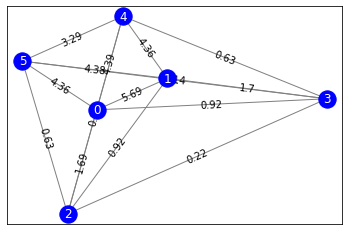

In [3]:
from Network import get_nx_graph_by_adjacent_mat, draw_graph

G = get_nx_graph_by_adjacent_mat(classical_res["MI"])
draw_graph(G)

## Most correlated subsets

In [6]:
corr_adjacent_mat=[[0.0, 0.05686422974791204, 0.01688342559421084, 0.00923050347926574, 0.0438784337237768, 0.043615348773295606], [0.05686422974791204, 0.0, 0.00923050347926574, 0.016984823342198085, 0.043615348773295606, 0.043794613240691074], [0.01688342559421084, 0.00923050347926574, 0.0, 0.0021556255819239617, 0.0012450419319145478, 0.006317482790596407], [0.00923050347926574, 0.016984823342198085, 0.0021556255819239617, 0.0, 0.006317482790596407, 0.0014123307378750144], [0.0438784337237768, 0.043615348773295606, 0.0012450419319145478, 0.006317482790596407, 0.0, 0.03286268696855375], [0.043615348773295606, 0.043794613240691074, 0.006317482790596407, 0.0014123307378750144, 0.03286268696855375, 0.0]]

In [7]:
from Network.GA._ga_selector import GACorrelationQsubsetSelector


G_corr = get_nx_graph_by_adjacent_mat(corr_adjacent_mat)
selector = GACorrelationQsubsetSelector(G_corr)

# Run GA selector with time budget 60 seconds
selector.run(time_budget=60)

# Get Result
results = selector.get_result()
print(results)


ModuleNotFoundError: No module named 'GA'

## Community detection

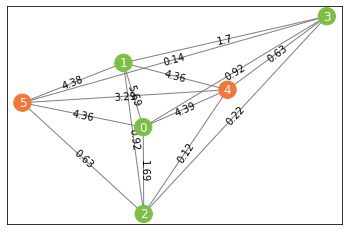

In [9]:
from Network._community_detection import detect_nx_graph_community, draw_community_graph
from Network import get_nx_graph_by_adjacent_mat

# Initial graph
G_corr = get_nx_graph_by_adjacent_mat(corr_adjacent_mat)

# Detect community
community_map = detect_nx_graph_community(G_corr)

# Draw community graph
draw_community_graph(G_corr, community_map, "output")




## Optimal Mapping

Optimal Mapping (graph) desribes the graph embedding of source graph in target graph.

In the network:

Nodes: represent the *qubits*.

Edge: represent *mutual information*.

We feed the generic constructor with both source weighted graph and target weighted graph. The optimal results will be evolved and optimized though a heuristic and generic hybrid algorithm.

In [11]:
from Network.GA_Graph_Embedding._ga_constructor import GAConstructor
from Network._quantum_chips import *


# Initial quantum chips
rigetti_16Q_Aspen = Rigetti_16Q_Aspen()
ibm_20Q_Johannesburg = IBM_20Q_Johannesburg()

# Search optimal mapping
embeding_selector = GAConstructor(G_corr, ibm_20Q_Johannesburg)
embeding_selector.run(time_budget = 60)

# Show optimal mapping
results = embeding_selector.get_results()
print(results)

KeyError: 0